# Explore OPM database with interactive query and graphs

## Notebook Requirements

In [1]:
%matplotlib inline 
%matplotlib notebook 

# Jupyter Notebook Formatting
# from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

# import for OPM dataframe access
import os

#import package OPMxplore
                        
# import for query [pypdb, sqlite3?, query?, pandasql?]
from pypdb import *
import pprint

# scipy stack
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# visualization stack [ipywidgets,nglview,matplotlib,seaborn,plotly]
import nglview as nv
from ipywidgets import interact

from plotly import __version__
print (__version__) # requires version >= 1.9.0

import plotly.offline as offline
# plotly.plotly.iplot() # online version
offline.init_notebook_mode(connected=True)    # inline 

import plotly.graph_objs as go
from plotly.widgets import GraphWidget
from IPython.display import display

import cufflinks as cf
cf.go_offline() # cufflinks offline

# PDB parsing
from Bio.PDB import PDBParser 
from Bio.PDB import MMCIFParser
# from Bio.PDB import *

# Query Functions (replace with import later)
# Query Functions
from pandasql import sqldf
sql_query = lambda q: sqldf(q, globals())

def make_sql(table,selection="*", options=""):
    return sql_query("SELECT "+selection+" FROM "+table+" "+options+";")

2.2.2


/Users/PnPofSila/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.

/Users/PnPofSila/miniconda3/envs/py36/lib/python3.6/site-packages/plotly/widgets/graph_widget.py:13: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



<IPython.core.display.Javascript object>

# About
A visual and statistcal interface into the OPM database

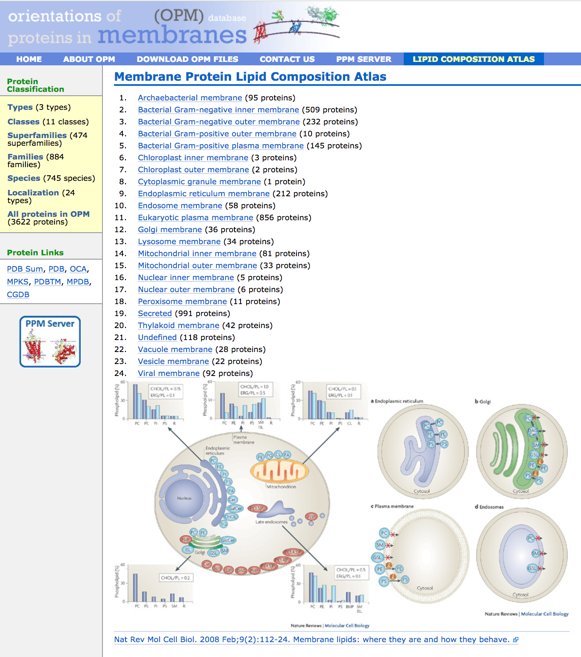

In [2]:
PATH = "../doc/"
Image(filename = PATH + "opm_snap.png", width=300, height=300)

# PART 1: Build dataframe and plotting functions

## (currently has code, replace with import statements) 

In [3]:
# replace with importing functions from OPMxmplore.py

def get_path(filename):
    """
    Locate the files in the appropriate directory relative to the current
    working directory. This assumes the current file is in
    "~/example_notebooks/", or in "~/pdb-search/"
    and that the data files are located in
    "~/pdb-search/data/sql_export/".
    
    os.path.join is used to provide cross-platform support.
    
    Returns:
    -------
    path : string
        The full path to the file
    """
    return os.path.join(os.path.dirname(os.getcwd()),
                        'OPMxplore',
                        'data',
                        'sql_export',
                        filename)

def load_data():
    """
    A Function to read all of the OPM database tables from csv files
    and load it into memory as a pandas dataframe.
    'protein.csv' contains the main table of protein information
    and the rest of the tables contain specific information about
    the various categories of proteins.  These are converted to dicts,
    and used to add the appropriate columns to the proteins dataframe
    
    Returns:
    -------
    df : pandas.DataFrame
        The data from the OPM database, including protein types,
        classes, superfamilies, families, species, and localization
    """
    
    # First we load all of the csv files into memory as pandas dataframes
    # proteins is the main table we are interested in
    proteins = pd.read_csv(get_path('protein.csv'), sep=';')

    # types, classes, families, and membranes will all become
    # dicts to interpret their various id's and turn them into names
    types = pd.read_csv(get_path('type.csv'), sep=';')
    classes = pd.read_csv(get_path('class.csv'), sep=';')
    families = pd.read_csv(get_path('family.csv'), sep=';')
    membranes = pd.read_csv(get_path('membrane.csv'), sep=';')

    # any given family superfamilies and species
    classifications = pd.read_csv(get_path('classification.csv'), sep=';')
    superfamilies = pd.read_csv(get_path('superfamily.csv'), sep=';')
    species = pd.read_csv(get_path('species.csv'), sep=';')

    # Next we make a series of dictionaries to translate:
    # family id --> family name
    # family id --> class number
    # family id --> type id
    # family id --> family tcdb code
    # family id --> family pfam code
    # family id --> superfamily_id
    family_names = dict(families[['id','name']].values)
    family_tcdbs = dict(families[['id','tcdb']].values)
    family_pfams = dict(families[['id','pfam']].values)
    
    # family id --> superfamily id
    # family id --> class id
    # family id --> type id
    family_to_superfam = dict(classifications[['family_id','superfamily_id']].values)
    family_to_class = dict(classifications[['family_id','class_id']].values)
    family_to_type = dict(classifications[['family_id','type_id']].values)

    # superfamily id --> superfamily name
    # superfamily id --> superfamily tcdb code
    # superfamily id --> superfamily pfam code
    superfamily_names = dict(superfamilies[['id','name']].values)
    superfamily_tcdbs = dict(superfamilies[['id','tcdb']].values)
    superfamily_pfams = dict(superfamilies[['id','pfam']].values)
    
    # class id --> class name
    # type id --> type name
    # species id --> species name
    # membrane id --> memrane name
    # memrane id --> membran abbreviation
    class_names = dict(classes[['id','name']].values)
    type_names = dict(types[['id','name']].values)
    species_names = dict(species[['id','name']].values)
    membrane_names = dict(membranes[['id','name']].values)
    membrane_abbr = dict(membranes[['id','abbreviation']].values)

    # now we use the dics from above to create new columns in the
    # proteins data frame containing the actual names of the
    # species, membrane, family, superfamily, etc
    proteins['species'] = proteins.species_id.replace(species_names)
    proteins['membrane'] = proteins.membrane_id.replace(membrane_names)
    proteins['membrane_abbr'] = proteins.membrane_id.replace(membrane_abbr)
    proteins['family'] = proteins.family_id.replace(family_names)
    proteins['family_pfam'] = proteins.family_id.replace(family_pfams)
    proteins['family_tcdb'] = proteins.family_id.replace(family_tcdbs)
    proteins['superfamily'] = proteins.family_id.replace(family_to_superfam).replace(superfamily_names)
    proteins['superfamily_tcdb'] = proteins.family_id.replace(family_to_superfam).replace(superfamily_tcdbs)
    proteins['superfamily_pfam'] = proteins.family_id.replace(family_to_superfam).replace(superfamily_pfams)
    proteins['class'] = proteins.family_id.replace(family_to_class).replace(class_names)
    proteins['type'] = proteins.family_id.replace(family_to_type).replace(type_names)
    
    return proteins
    
# load the data from excel files located in this directory
def load_excell_data():
    """
    Deprecated: Load the OPM database into memory as a pandas data frame.
    The protein data was downloaded from the OPM database
    as a MySQL dump file:
    http://opm.phar.umich.edu/OPM-2016-10-10.sql
    
    The data is was then converted to an excel file stored locally:
    "pdb-search/data/OPM_data_from_MySQL.xlsx"
    
    Returns:
    -------
    df : pandas.DataFrame
        The data from the OPM database, including protein types,
        classes, superfamilies, families, species, and localization
    """
    return pd.read_excel(get_path("OPM_data_from_MySQL.xlsx"), "Sheet1")

In [4]:
df_proteins = load_data()

In [5]:
df_proteins.head(3)

id  family_id  species_id  membrane_id pdbid  \
0   1         35           9            3  1qjp   
1   2        390           9            3  1qj8   
2   3        363          24            3  1p4t   

                                                name resolution topology  \
0  Outer membrane protein A (OMPA), disordered loops       1.65     A in   
1                    Outer membrane protein X (OMPX)       1.90     A in   
2                        Outer membrane protein NspA       2.55     A in   

   thickness  thicknesserror      ...        \
0       25.4             1.5      ...         
1       23.6             2.8      ...         
2       24.9             2.4      ...         

                                 membrane         membrane_abbr  \
0  Bacterial Gram-negative outer membrane  Bact. Gram-neg outer   
1  Bacterial Gram-negative outer membrane  Bact. Gram-neg outer   
2  Bacterial Gram-negative outer membrane  Bact. Gram-neg outer   

                            family family_pfam  family_tcdb  \
0                      OmpA family     PF01389          NaN   
1  Enterobacterial Ail/Lom protein     PF06316          NaN   
2                   Opacity porins     PF02462          NaN   

                         superfamily superfamily_tcdb superfamily_pfam  \
0  OmpA-OmpF porin family (n=8,S=10)            1.B.6              NaN   
1  OmpA-OmpF porin family (n=8,S=10)            1.B.6              NaN   
2          Opacity porins (n=8,S=10)              NaN          PF02462   

                       class           type  
0  Beta-barrel transmembrane  Transmembrane  
1  Beta-barrel transmembrane  Transmembrane  
2  Beta-barrel transmembrane  Transmembrane  

[3 rows x 30 columns]

In [20]:
# plotting library

def brill_3d(high_type,query_id,x,y,z):
    """
    first argument is the highest level category available in OPM
    high_type: choose 'Transmembrane', 'Peptides', 'Monotopic/peripheral'
    query_id: df_id 
    x:column name
    y:column name
    z:column name
    """
    df_inp = query_dict[query_id]
    df_inp[df_inp['type']==high_type].iplot(kind='scatter3d',x=x,y=y,z=z,size=15,
                                                     categories='class',text='name',
                                                  title='Brilliant 3D Protein Scatter', colors=
                                                  ['blue','pink','yellow'],width=0.5,margin=(0,0,0,0),opacity=1,
                                                  theme='white', yTitle='hydrophobic thickness',zTitle='gibbs')
    #add titles

xvars = list(df_proteins.columns)
yvars = ['type','membrane_abbr', 'family', 'species','class']

# list of query based plotting functions
def stat_plot(query_id, xvar, yvar, title):
    # plot aesthetics
    sns.set()
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    # get data
    df_inp = query_dict[query_id]
    # Create violin plot
    ax1 = sns.violinplot(x=xvar,
                   y=yvar, 
                   data=df_inp,
                    saturation=0.5,
                   inner='box', # Remove the bars inside the violins
                  ax=ax)

    ax1 = sns.swarmplot(x=xvar, y=yvar, data=df_inp, alpha='0.5', color='k')
    # Set title with matplotlib
    plt.title(title)
    
def swarm_plot(query_id, xvar, yvar, title):
    # plot aesthetics
    sns.set()
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    # get data
    df_inp = query_dict[query_id]
    # get swarm
    ax1 = sns.swarmplot(x=xvar, y=yvar, data=df_inp, alpha='0.5', color='r')
    # Set title with matplotlib
    plt.title(title)
    
def scatter_plot(query_id, category):
    
    # get data
    df_inp = query_dict[query_id]
    
    df_inp.iplot(kind = 'scatter', mode = 'markers', y = 'thickness', 
             x = 'gibbs', text='pdbid',
             xTitle = 'dG to fold or insert in membrane',
             yTitle = 'Hydrophobic_Thickness', theme='white',categories=category, colors = ['blue','pink','yellow','green']
             )

# PART 2: Load dataframe and setup saved queries

In [21]:
# load full dataframe
df_proteins = load_data()

# make query
qr_text ="""
    SELECT *
    FROM df_proteins
    WHERE (name LIKE '%channel%' OR name LIKE '%porin%') 
    AND NOT (name LIKE '%domain%' OR name LIKE '%monomer%') 
    """
 #AND (Class GLOB 'Beta-barrel transmembrane' )
df_query_channel = sql_query(qr_text)

# save query

# Static lists for purpose of illustration
query_ids = ["df_query_channel", "df_proteins"]
query_dfs = [df_query_channel, df_proteins]
query_ids_dfs = zip(query_ids,query_dfs)

query_dict = {}
for strid, df in query_ids_dfs:
    query_dict[strid] = df
    
## Aliter create query
#option 2: use a wrapper function that combines takes a table name and a selection as options

my_options = """
WHERE (name LIKE '%channel%' OR name LIKE '%porin%') 
AND NOT (name LIKE '%domain%' OR name LIKE '%monomer%') 
AND (Class GLOB 'Beta-barrel transmembrane' )
"""
results = make_sql("df_proteins","pdbid",my_options)
results.head(2)
results.shape
#print (sql_query("SELECT * FROM df_proteins LIMIT 10;").head())

pdbid
0  3pox
1  2fgq

(61, 1)

# PART 3: OPM InfoGraphic

## Quick Demo

In [16]:
%%html
#embed a gif 
# this is a placeholder
<img src='https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif'>

# Explore the OPM database

### Classification in the OPM database
The OPM database has the following levels of heirarchy:

*Type: transmembrane proteins, monotopic/peripheral proteins, or membrane-active peptides.

*Class: all-α, all-β, α+β, α/β, or nonregular proteins.

*Superfamily: evolutionarily related proteins with superimposable 3D structures.

*Family: proteins with detectable sequence homology.

### Demo Aims
The purpose of this demo is to show the user how to make a query on the database, and provide starting points for analysis via interactive 3D plots and focused statiscal plots.

The demo will meander through the database looking for properties that might be unique to the protein type transmembrane, the category "channel proteins" in the transmembrane type, and the secondary structure "beta-barrel" or "alpha-helical" in channel transmembrane proteins. These properties include the hydrophobic thickness, gibbs free energy of transfer from water to membrane. The latter relates to how stable a protein is in membrane versus water, with more negative corresponding to more stable. 

### Demo Overview

*1. Query the database for Transmembrane category

*2. Query the database using keyword "channel" 

*3. Display 3D plot of each result x: membrane localization y: hydrophobic thickness z: gibbs free energy (the three measures computed for most membrane proteins in the OPM database). 

*4. Toggle between secondary structures classifications: a-helical, bitopic, and beta-barrel

*5. Visualize protein outliers 

*6. Check for relationship 

## Query

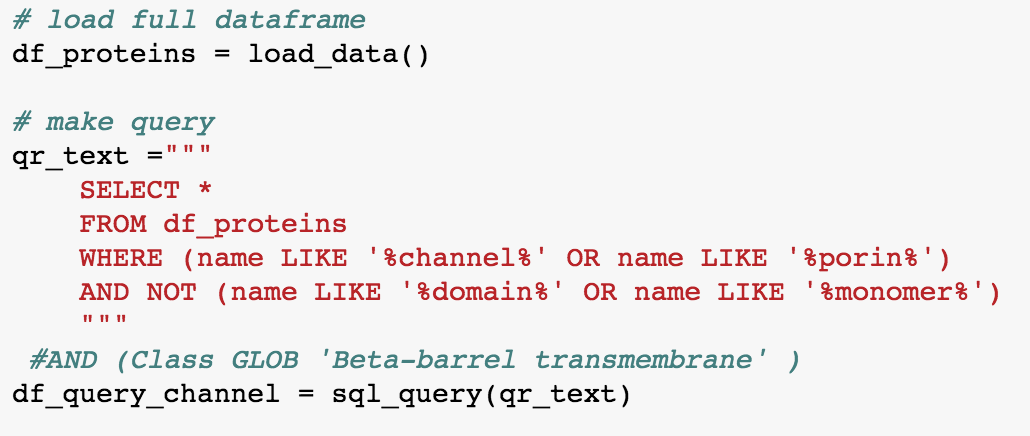

## 3D Scatter of all proteins in the *Transmembrane* dataframe
Observe the clustering of alpha-helical proteins vs beta-barrel proteins vs biopic proteins. Turning off categories on the right panel, we observe that bitopic proteins have more positive gibbs free energy of insertion than other two categories. The Beta-barrel population is more localized at the Bacterial Gram-negative outer membrane. Rotate the 3D graph such that you face x-axis: hydrophobic thickness and z-axis: gibbs free energy. We observe that majority of the proteins are clustered at 30 Angstrom in hydrophobic thickness. This also corresponds to be the average height or thickness of the membrane of cells.

In [22]:
brill_3d('Transmembrane','df_proteins','membrane','thickness','gibbs')

The most apparent clustering is along the z-axis for each cateogry, with a-helical TM proteins having the highest spread in gibbs free energy and types of membranes.

## 3D Scatter of proteins in key-word query Transmembrane  dataframe
We subset channels from the transmembrane datraframe. Of considerable interest is the clustering of the proteins at the Localization of type Bacterial Gram-neg outer membrane. In addition, with the exception of one protein, the remainder are all subseted to the "outer membrane". Two data points stand out - at 40 Angstrom thickness, MSPA protein is the tallest protein in the set; and, at -142.5 dG of transfer to membrane osmoporin OMPC appears to be the most stable in its membrane.

In [23]:
brill_3d('Transmembrane','df_query_channel','membrane','thickness','gibbs')

## Toggling between the secondary structures beta barrel vs alpha-helical: 

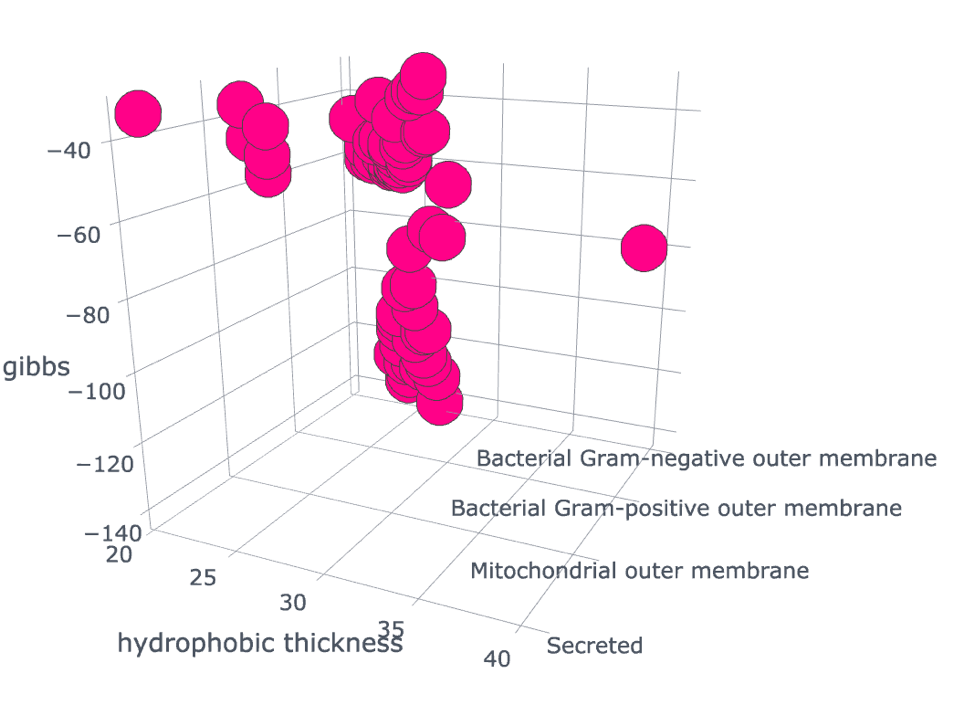

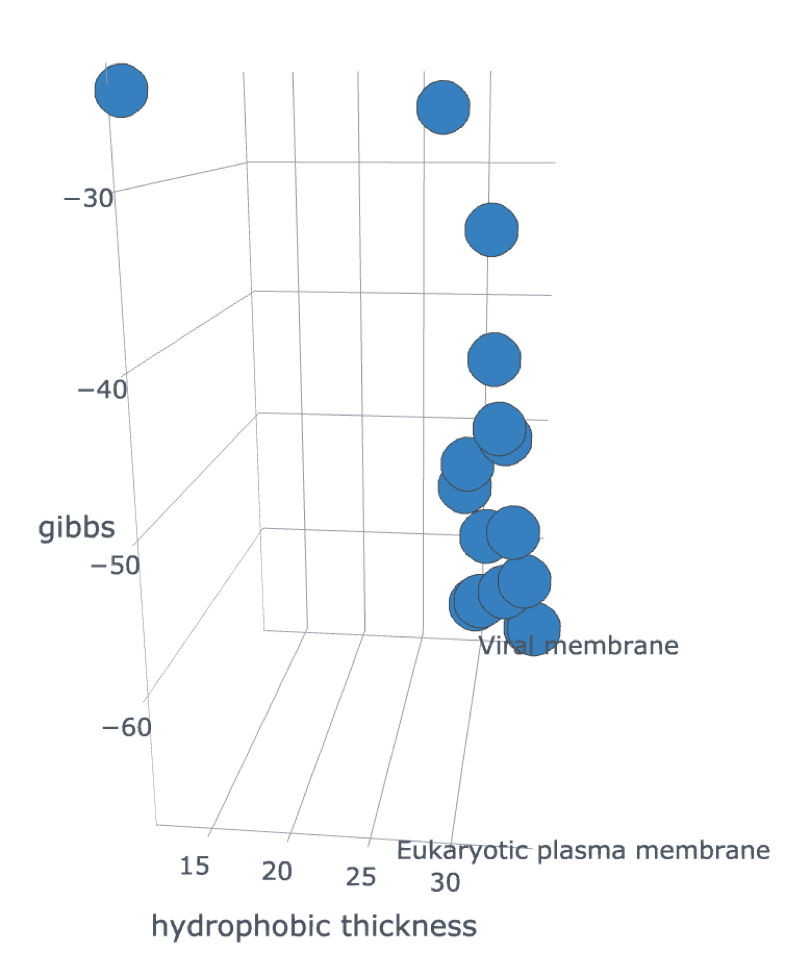

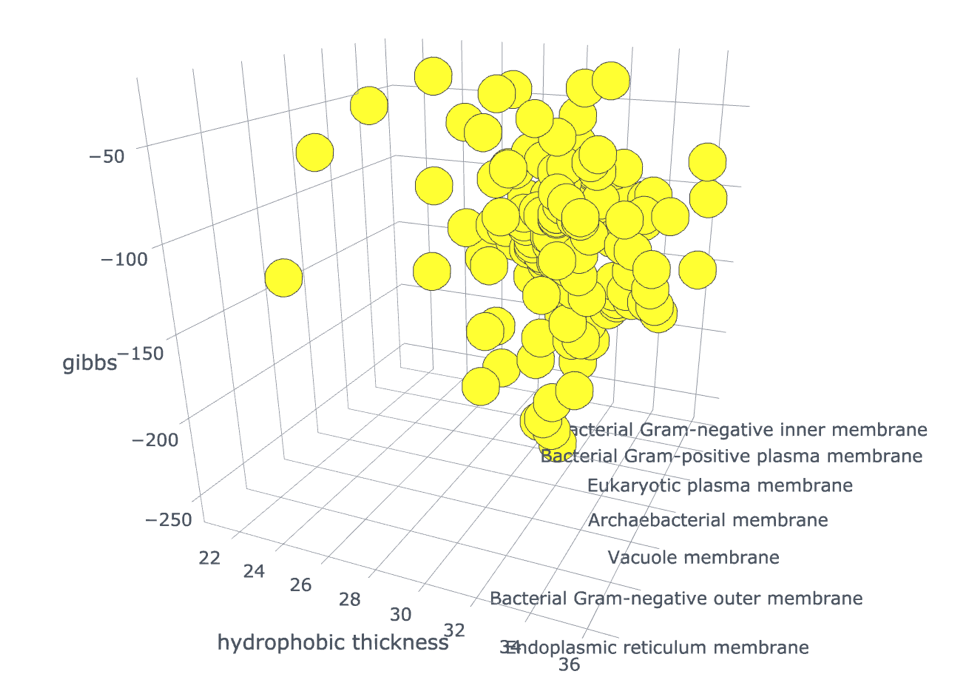

In [25]:
### beta barrels

PATH = "../doc/"
Image(filename = PATH + "opm_tm_beta.png", width=300, height=300)

### bitopics

PATH = "../doc/"
Image(filename = PATH + "opm_tm_bitopic.png", width=300, height=300)

### alpha-helices

PATH = "../doc/"
Image(filename = PATH + "opm_tm_alpha.png", width=300, height=300)

Bitopic proteins are popular with viral coats; Beta barrels are popular with bacterial gram negative bacteria outer-membrane; Alpha helical proteins are popular with eukaryotic membranes, bacterial and arachae. While these may be interesting features (structure sequence function relationship) to explore, we should note that the proteins in the database are only structures those that could be experimentally solved. The latter biases the types of membranes and organisms proteins can be obtained from. 

# Visualize proteins of interest

## Tallest beta barrel
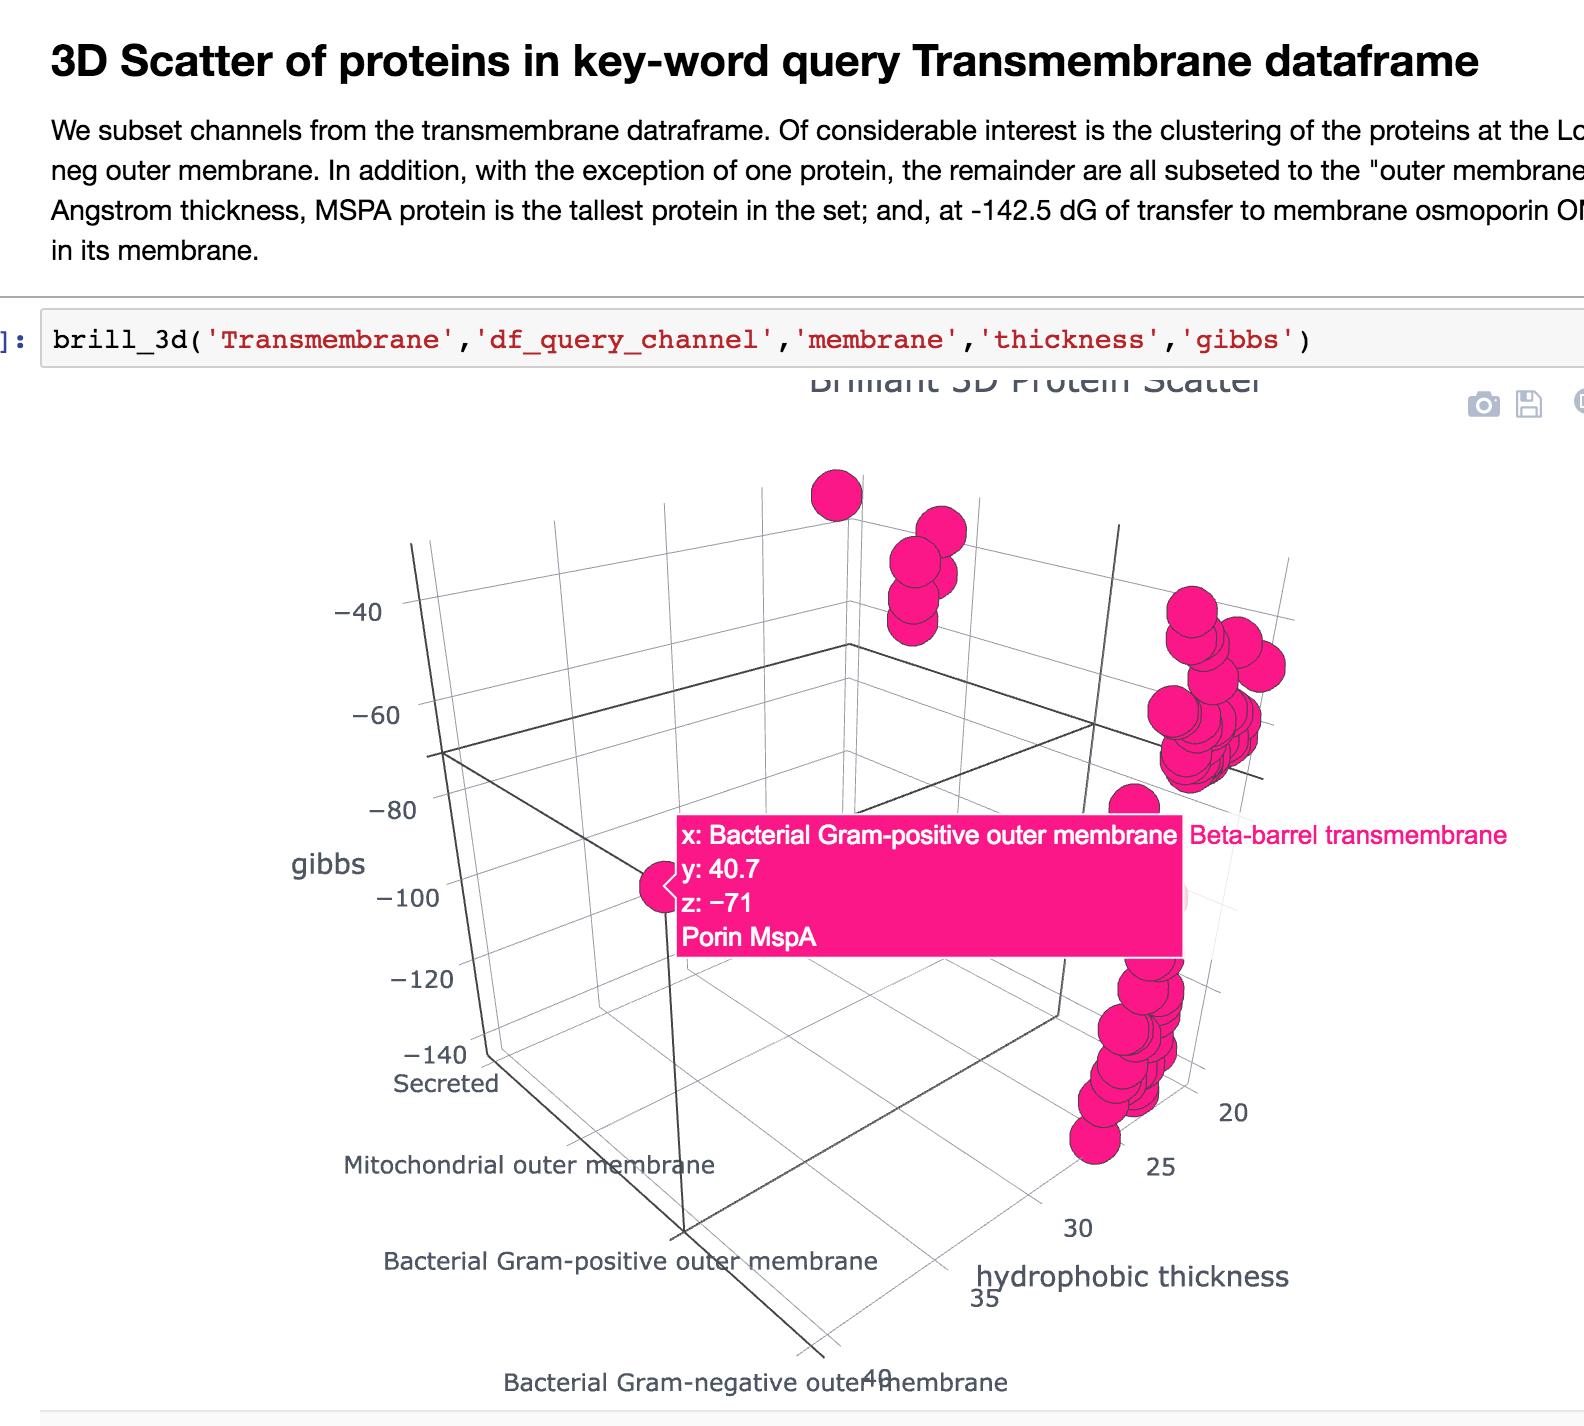

## most stable beta-barrel

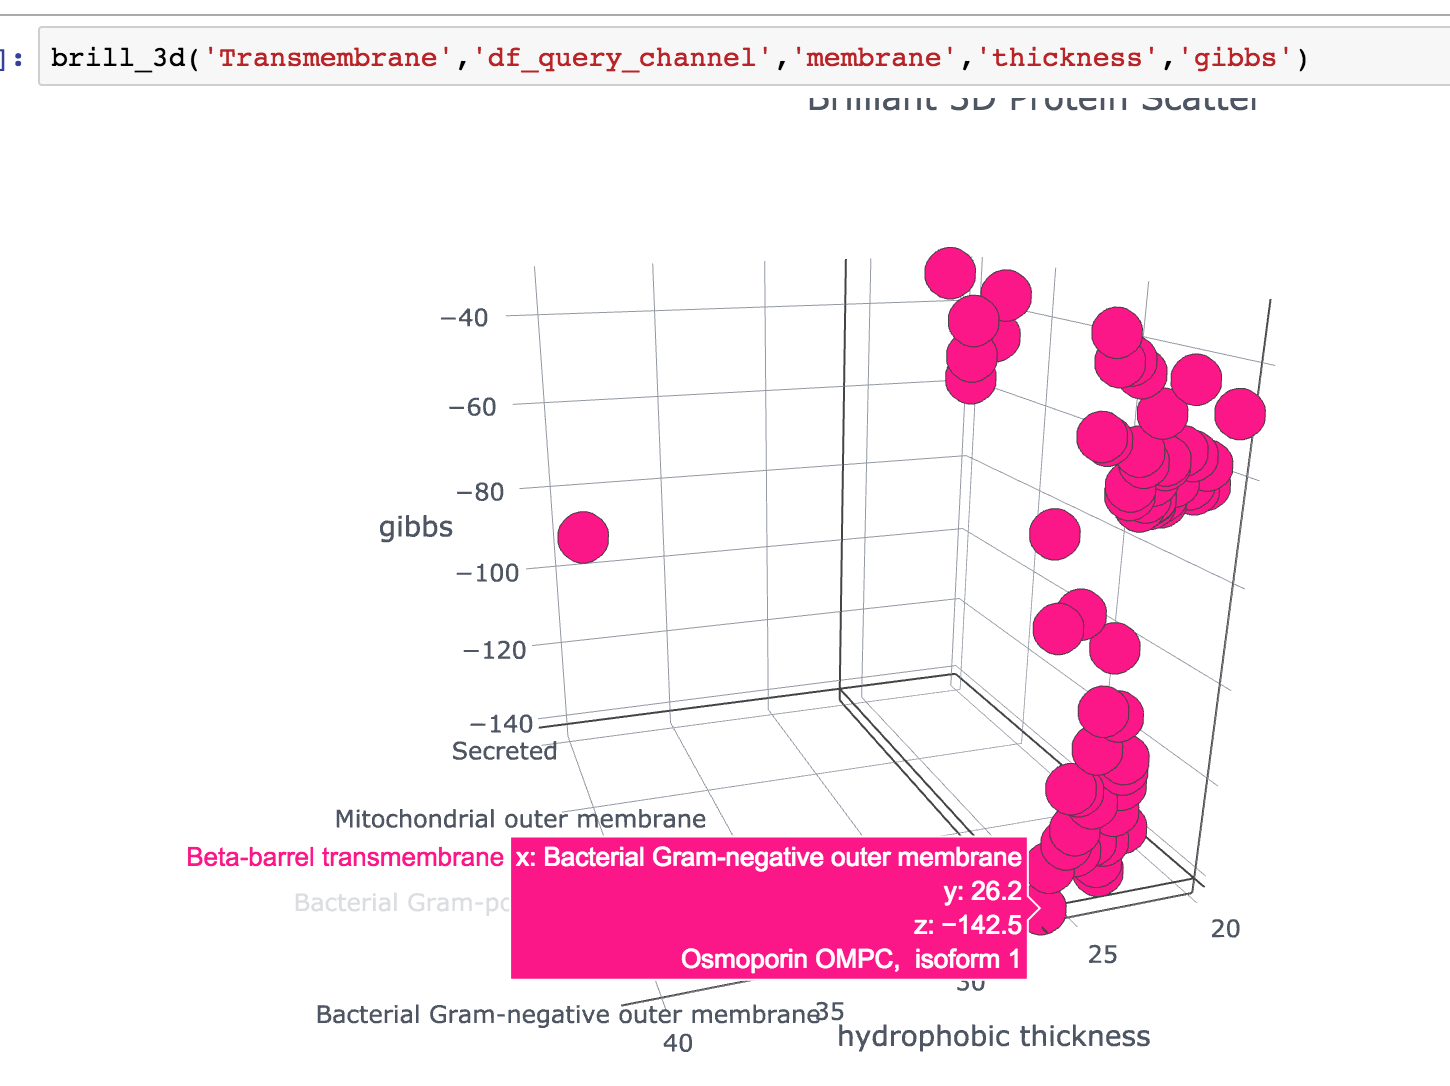

In [26]:
qr_text ="""
    SELECT name, pdbid, species
    FROM df_proteins
    WHERE (name LIKE '%MSPA%' OR name LIKE '%osmoporin%') 
    """
df_query_clicked = sql_query(qr_text)
df_query_clicked

name pdbid                  species
0                  Porin MspA  1uun  Mycobacterium smegmatis
1              Osmoporin OMPC  2j1n         Escherichia coli
2  Osmoporin OMPC,  isoform 1  2ixx         Escherichia coli
3   Osmoporin OMPC, isoform 2  2ixw         Escherichia coli
4              Osmoporin OMPC  3upg   Salmonella typhimurium

In [12]:
clicked_protein = "1uun"     # fetch clicked protein
view1 = nv.show_pdbid(clicked_protein) # access PDB online, and create cartoon
view1 # display
# TO DO: add PDB_ID, Protein_Name, type, class (from the OPM database, as metadata when hovering) 
# add metadeta to nglview rendering as well
# TO DO: add iframe to embed this demo display

clicked_protein = "2ixx"
view2 = nv.show_pdbid(clicked_protein) # access PDB online, and create cartoon
view2

A Jupyter Widget

A Jupyter Widget

### Display the tallest and most stable proteins
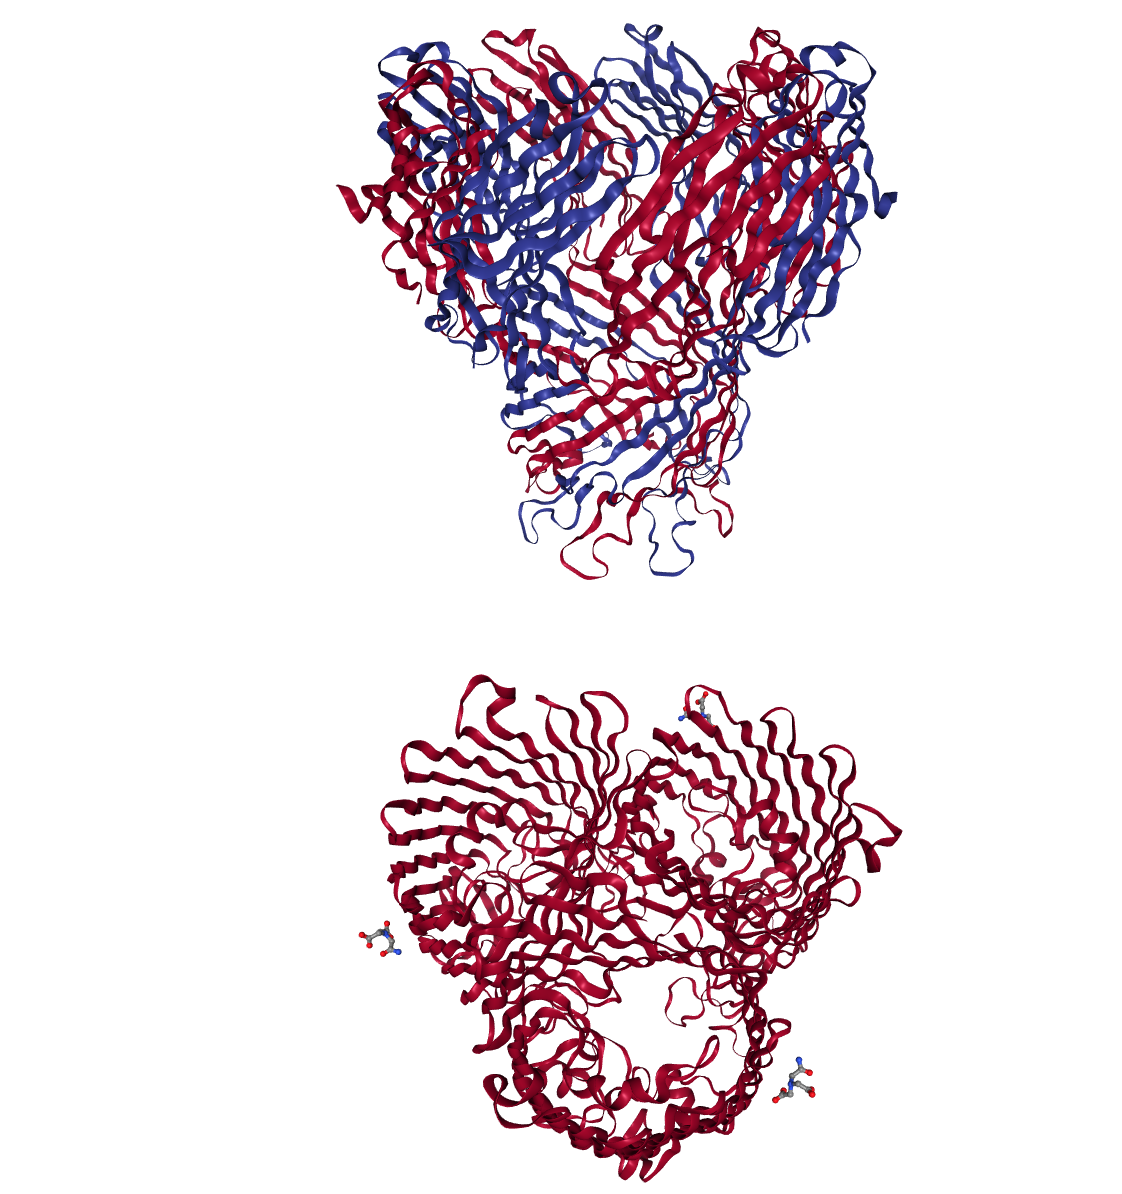

### Display Visual differences between the three classes 

In [22]:
df_proteins[df_proteins['type']=='Transmembrane'][df_proteins['class'].str.contains('Bitopic')].head(1).pdbid
df_proteins[df_proteins['type']=='Transmembrane'][df_proteins['class'].str.contains('Alpha-helical')].head(1).pdbid
df_proteins[df_proteins['type']=='Transmembrane'][df_proteins['class'].str.contains('Beta-barrel')].head(1).pdbid

view = nv.show_pdbid('3lbw')
view
view = nv.show_pdbid('1ots')
view
view = nv.show_pdbid('1qjp')
view

/Users/PnPofSila/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



3    3lbw
Name: pdbid, dtype: object

/Users/PnPofSila/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



29    1ots
Name: pdbid, dtype: object

/Users/PnPofSila/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0    1qjp
Name: pdbid, dtype: object

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# PART 4: Interactive Visualization with Drop Down Menu

## Explore hydrophobic thickness vs. Gibbs free energy of insertion in membrane
In this case choose one of the queries and look for a trend in protein's height in the membrane vs gibbs free energy of insertion.

In [24]:
interact(scatter_plot, query_id=query_ids, category=['species','membrane'])

A Jupyter Widget

<function __main__.scatter_plot>

### Query the pdbid with highest and lowest hydrophobic thickenss, at about the same ddG

In [25]:
nv.show_pdbid("1uun")
nv.show_pdbid("4q79")

A Jupyter Widget

A Jupyter Widget

In [26]:
interact(stat_plot, query_id=query_ids, xvar=xvars, yvar=yvars, title="write your own")

A Jupyter Widget

<function __main__.stat_plot>

In [27]:
interact(swarm_plot, query_id=query_ids, xvar=xvars, yvar=yvars, title="write your own")

A Jupyter Widget

<function __main__.swarm_plot>

## Display Database Relevant Counts

In [ ]:
cols = df_proteins.columns
relevant_cols = ['type','class','superfamily','family','membrane','pdbid']
df_proteins[relevant_cols].nunique().iplot(kind='bar',theme='white')
df_proteins['membrane'].nunique()
df_proteins['membrane'].value_counts().iplot(kind='bar', theme='white')


# to do : add dropdown to select category to show for counts